### Load the data

In [158]:
import pandas as pd

test = pd.read_csv('test.csv')
train = pd.read_csv('train.csv')

test.head()

,Index,Sentiment,Text
0,0,1,@stellargirl I loooooooovvvvvveee my Kindle2. ...
1,1,1,Reading my kindle2... Love it... Lee childs i...
2,2,1,"Ok, first assesment of the #kindle2 ...it fuck..."
3,3,1,@kenburbary You'll love your Kindle2. I've had...
4,4,1,@mikefish Fair enough. But i have the Kindle2...


### Lets see if there is any missing values

In [159]:
print(test.isna().sum())
print(train.isna().sum())

Index        0
Sentiment    0
Text         0
dtype: int64
Index        0
Sentiment    0
Text         0
dtype: int64


### Take a look at the sentiment distribution

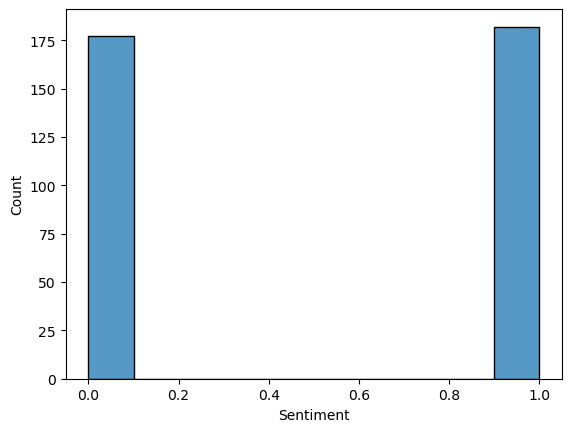

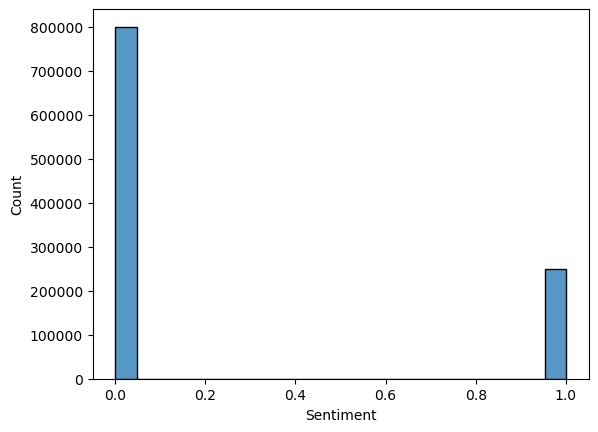

In [160]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(data=test['Sentiment'])
plt.show()

sns.histplot(data=train['Sentiment'])
plt.show()

### There is significantly more negative sentiment than positive in the training data. We can use just a portion of the 0 sentiment to match the 1

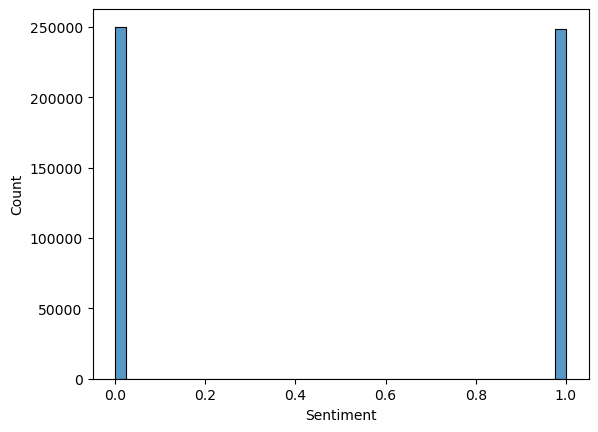

In [161]:
positive = train[train['Sentiment'] == 1].head(250000)
negative = train[train['Sentiment'] == 0].head(250000)
train = pd.concat([positive, negative])

sns.histplot(data=train['Sentiment'])
plt.show()

### We can start preprocessing the raw text for sentiment analysis

In [162]:
import nltk
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem.snowball import SnowballStemmer
import re
import contractions
import string
import spacy

nltk.download('wordnet')
nltk.download('omw-1.4')

nlp = spacy.load("en_core_web_sm")
lemmer = WordNetLemmatizer()
stemmer = SnowballStemmer(language='english')

#### Lower case everything
def lower_case(string: str) -> str:
    return string.lower()

train['Text'] = train['Text'].apply(lower_case)
test['Text'] = test['Text'].apply(lower_case)

#### Remove numbers
def remove_digits(string: str) -> str:
    return re.sub('[0-9]', '', string)

train['Text'] = train['Text'].apply(remove_digits)
test['Text'] = test['Text'].apply(remove_digits)

#### Expand contractions
def expand_contractions(string: str) -> str:
    return contractions.fix(string)

train['Text'] = train['Text'].apply(expand_contractions)
test['Text'] = test['Text'].apply(expand_contractions)

#### Remove punctuation
def remove_special(text: str) -> str:
    words = word_tokenize(text)
    return [lemmer.lemmatize(w) for w in words if w not in list(string.punctuation)]

train['Text'] = train['Text'].apply(remove_special)
test['Text'] = test['Text'].apply(remove_special)

[nltk_data] Downloading package wordnet to
[nltk_data]     /home/markpolkhovskiy/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /home/markpolkhovskiy/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


### The text in the dataframe is now the cleaned text. Time to train the Word2Vec model.

In [163]:
from gensim.models import Word2Vec

model = Word2Vec(sentences=train['Text'], vector_size=100, window=5, min_count=1, workers=4)

### With this model we can generate the word vector for each word in each data point and average it to get one vector for the document. This will be passed into the regression models.

In [164]:
import numpy as np

vectors_train = []
for sentence in train['Text']:
    words = []
    for word in sentence:
        words.append(model.wv[word])
    vectors_train.append(np.array(words).mean(axis=0))
train['Word2Vec'] = vectors_train

vectors_test = []
for sentence in test['Text']:
    words = []
    for word in sentence:
        try:
            words.append(model.wv[word])
        except:
            continue
    vectors_test.append(np.array(words).mean(axis=0).tolist())
test['Word2Vec'] = vectors_test

### The word vector averages are now stored in the dataframe. We can create the inputs for the regression models.

In [165]:
x_train = vectors_train
y_train = train['Sentiment'].to_numpy()

x_test = vectors_test
y_test = test['Sentiment'].to_numpy()

### Build and train the models

In [166]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB

lc = LogisticRegression(max_iter=1000)
nbc = GaussianNB()

lc.fit(x_train, y_train)
nbc.fit(x_train, y_train)

GaussianNB()

### Test the models

In [167]:
y_lc_predicted = lc.predict(x_test)
y_lc_pred_proba = lc.predict_proba(x_test)

y_nbc_predicted = nbc.predict(x_test)
y_nbc_pred_proba = nbc.predict_proba(x_test)

### Evaluate the model

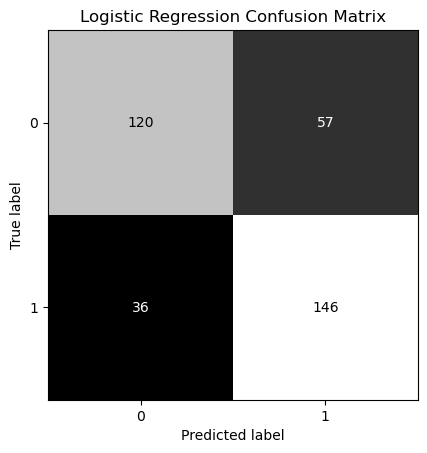

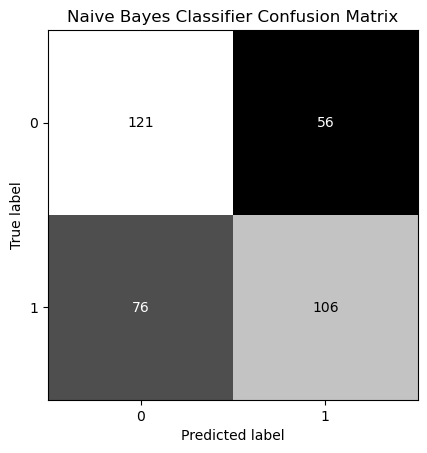

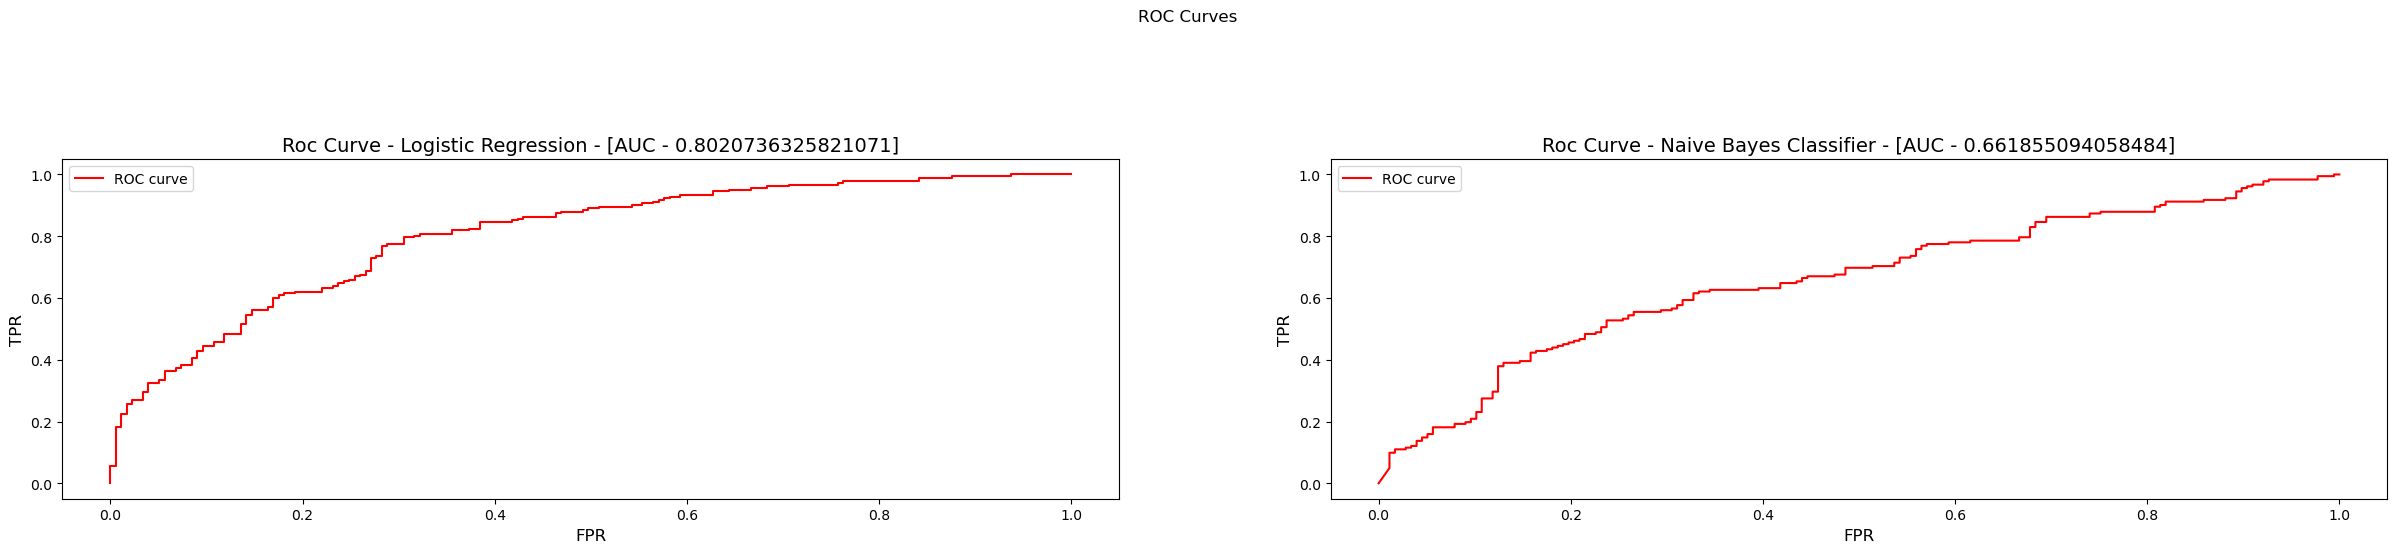

In [168]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, roc_curve, auc, classification_report

models = ['Logistic Regression', 'Naive Bayes Classifier']
predictions = [y_lc_predicted, y_nbc_predicted]
pred_probabilities = [y_lc_pred_proba, y_nbc_pred_proba]

plot = 1

for model, prediction, pred_proba in zip(models, predictions, pred_probabilities):
    disp = ConfusionMatrixDisplay(confusion_matrix(y_test.ravel(), prediction))
    disp.plot(
        include_values=True,
        cmap='gray',
        colorbar=False
    )
    disp.ax_.set_title(f"{model} Confusion Matrix")

plt.figure(figsize=(30, 15))
plt.suptitle("ROC Curves")
plot_index = 1

for model, prediction, pred_proba in zip(models, predictions, pred_probabilities):
    fpr, tpr, thresholds = roc_curve(y_test, pred_proba[:, 1])
    auc_score = auc(fpr, tpr)
    plt.subplot(3, 2, plot_index)
    plt.plot(fpr, tpr, 'r', label='ROC curve')
    plt.title(f'Roc Curve - {model} - [AUC - {auc_score}]', fontsize=14)
    plt.xlabel('FPR', fontsize=12)
    plt.ylabel('TPR', fontsize=12)
    plt.legend()
    plot_index += 1
plt.show()

### We can try the FastText word embedding algorithm

In [169]:
from gensim.models import FastText

model = FastText(sentences=train['Text'], vector_size=100, window=5, min_count=1, workers=4)

### This model should be able to handle out of vocab words

In [170]:
vectors_train = []
for sentence in train['Text']:
    words = []
    for word in sentence:
        words.append(model.wv[word])
    vectors_train.append(np.array(words).mean(axis=0))
train['Word2Vec'] = vectors_train

vectors_test = []
for sentence in test['Text']:
    words = []
    for word in sentence:
        words.append(model.wv[word])
    vectors_test.append(np.array(words).mean(axis=0).tolist())
test['Word2Vec'] = vectors_test

### Build and train the models

In [171]:
x_train = vectors_train
x_test = vectors_test

lc = LogisticRegression(max_iter=1000)
nbc = GaussianNB()

lc.fit(x_train, y_train)
nbc.fit(x_train, y_train)

GaussianNB()

### Test the models

In [172]:
y_lc_predicted = lc.predict(x_test)
y_lc_pred_proba = lc.predict_proba(x_test)

y_nbc_predicted = nbc.predict(x_test)
y_nbc_pred_proba = nbc.predict_proba(x_test)

### Evaluate the models

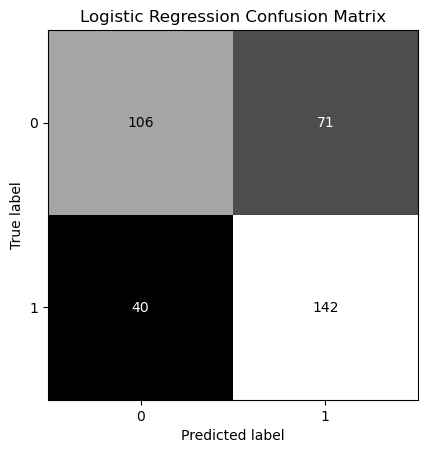

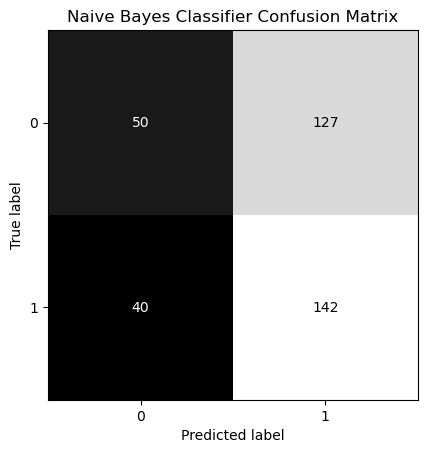

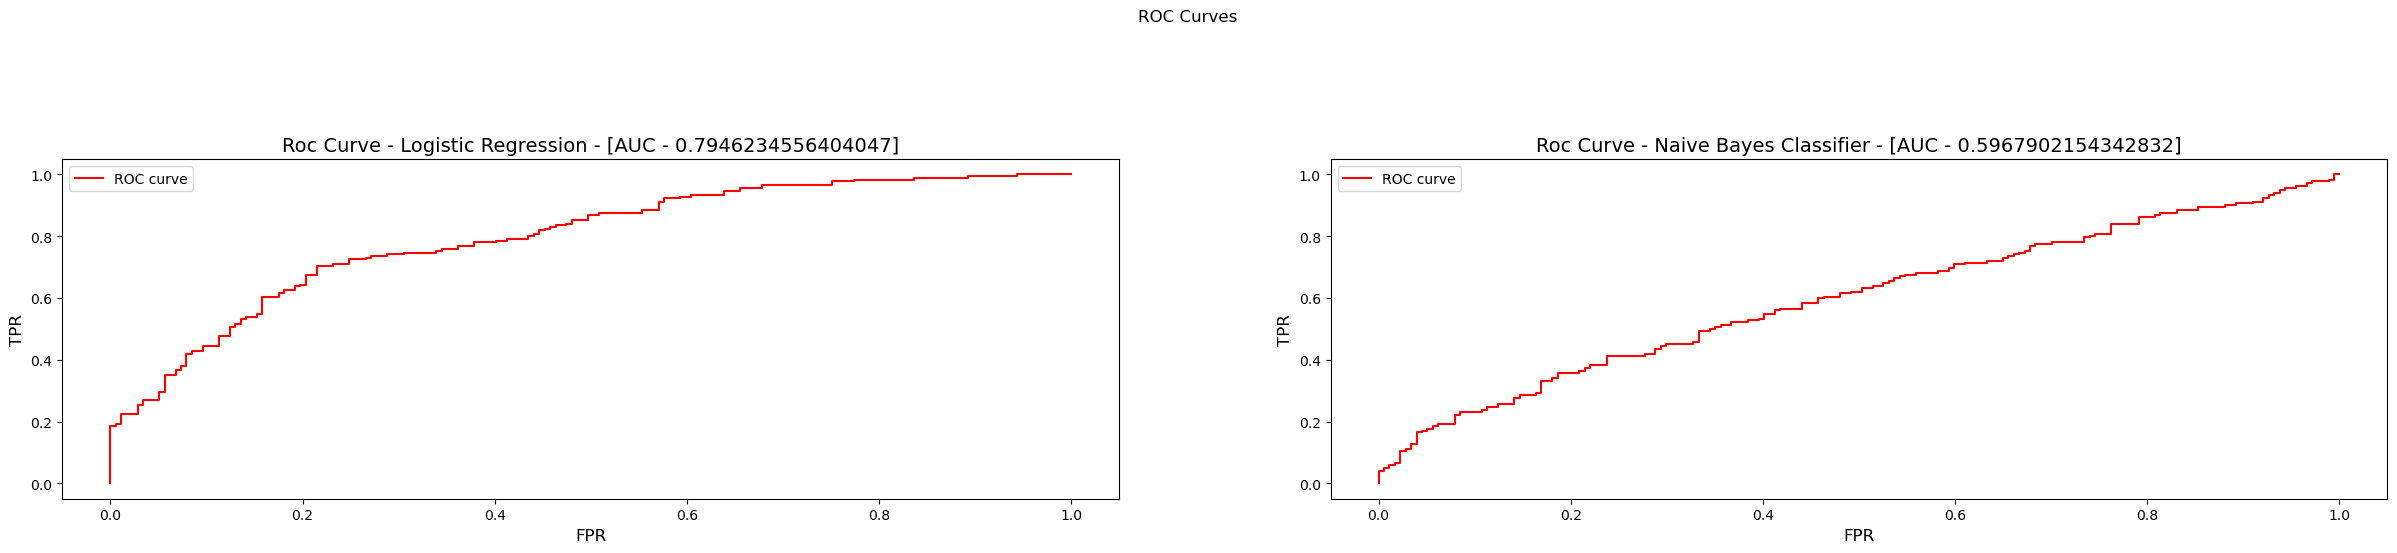

In [173]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, roc_curve, auc, classification_report

models = ['Logistic Regression', 'Naive Bayes Classifier']
predictions = [y_lc_predicted, y_nbc_predicted]
pred_probabilities = [y_lc_pred_proba, y_nbc_pred_proba]

plot = 1

for model, prediction, pred_proba in zip(models, predictions, pred_probabilities):
    disp = ConfusionMatrixDisplay(confusion_matrix(y_test.ravel(), prediction))
    disp.plot(
        include_values=True,
        cmap='gray',
        colorbar=False
    )
    disp.ax_.set_title(f"{model} Confusion Matrix")

plt.figure(figsize=(30, 15))
plt.suptitle("ROC Curves")
plot_index = 1

for model, prediction, pred_proba in zip(models, predictions, pred_probabilities):
    fpr, tpr, thresholds = roc_curve(y_test, pred_proba[:, 1])
    auc_score = auc(fpr, tpr)
    plt.subplot(3, 2, plot_index)
    plt.plot(fpr, tpr, 'r', label='ROC curve')
    plt.title(f'Roc Curve - {model} - [AUC - {auc_score}]', fontsize=14)
    plt.xlabel('FPR', fontsize=12)
    plt.ylabel('TPR', fontsize=12)
    plt.legend()
    plot_index += 1
plt.show()

### We will move onto the TF-IDF feature extraction algorithm. Need to join the text back together

In [174]:
def combine(words: list[str]) -> str:
    return " ".join(words)

train_x = train['Text'].apply(combine).to_list()
test_x = test['Text'].apply(combine).to_list()

### Vectorize the training and testing sets

In [175]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()

x_train = vectorizer.fit_transform(train_x)
x_test = vectorizer.transform(test_x)

### Build and train the models

In [176]:
from sklearn.naive_bayes import MultinomialNB

lc = LogisticRegression(max_iter=1000)
nbc = MultinomialNB()

lc.fit(x_train, y_train)
nbc.fit(x_train, y_train)

MultinomialNB()

### Test the models

In [177]:
y_lc_predicted = lc.predict(x_test)
y_lc_pred_proba = lc.predict_proba(x_test)

y_nbc_predicted = nbc.predict(x_test)
y_nbc_pred_proba = nbc.predict_proba(x_test)

### Evaluate the models

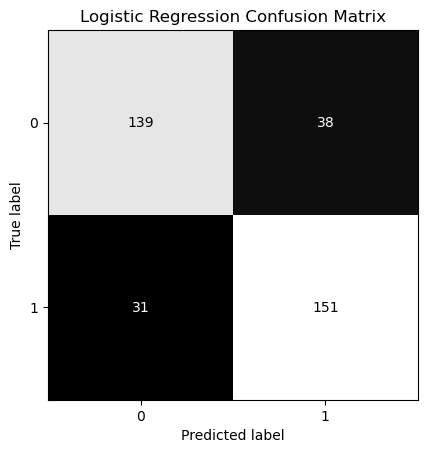

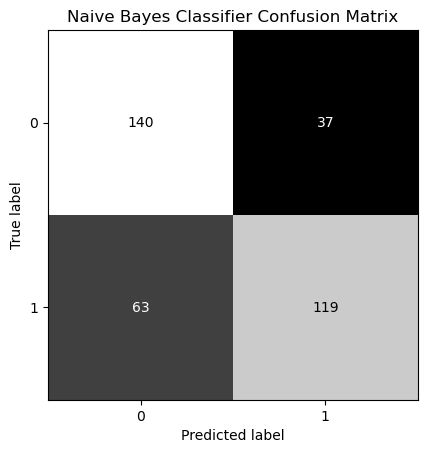

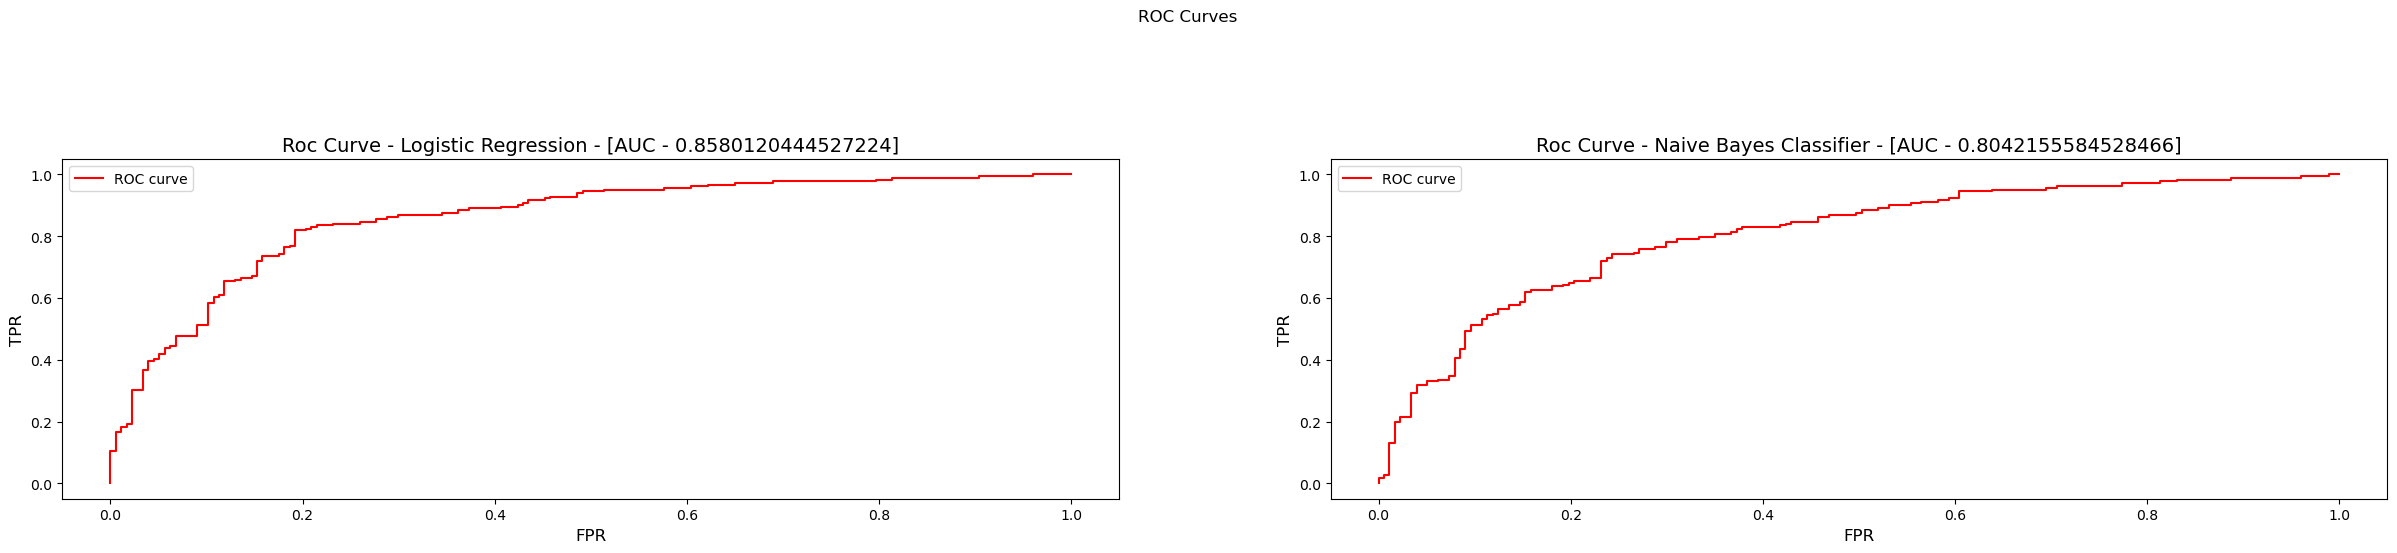

In [178]:
models = ['Logistic Regression', 'Naive Bayes Classifier']
predictions = [y_lc_predicted, y_nbc_predicted]
pred_probabilities = [y_lc_pred_proba, y_nbc_pred_proba]

plot = 1

for model, prediction, pred_proba in zip(models, predictions, pred_probabilities):
    disp = ConfusionMatrixDisplay(confusion_matrix(y_test.ravel(), prediction))
    disp.plot(
        include_values=True,
        cmap='gray',
        colorbar=False
    )
    disp.ax_.set_title(f"{model} Confusion Matrix")

plt.figure(figsize=(30, 15))
plt.suptitle("ROC Curves")
plot_index = 1

for model, prediction, pred_proba in zip(models, predictions, pred_probabilities):
    fpr, tpr, thresholds = roc_curve(y_test, pred_proba[:, 1])
    auc_score = auc(fpr, tpr)
    plt.subplot(3, 2, plot_index)
    plt.plot(fpr, tpr, 'r', label='ROC curve')
    plt.title(f'Roc Curve - {model} - [AUC - {auc_score}]', fontsize=14)
    plt.xlabel('FPR', fontsize=12)
    plt.ylabel('TPR', fontsize=12)
    plt.legend()
    plot_index += 1
plt.show()

### We can take a look at the word count bag-of-words for sentiment analysis

In [179]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()

x_train = vectorizer.fit_transform(train_x)
x_test = vectorizer.transform(test_x)

### Build and train the models

In [180]:
lc = LogisticRegression(max_iter=1000)
nbc = MultinomialNB()

lc.fit(x_train, y_train)
nbc.fit(x_train, y_train)

MultinomialNB()

### Test the model

In [181]:
y_lc_predicted = lc.predict(x_test)
y_lc_pred_proba = lc.predict_proba(x_test)

y_nbc_predicted = nbc.predict(x_test)
y_nbc_pred_proba = nbc.predict_proba(x_test)

### Evaluate the models

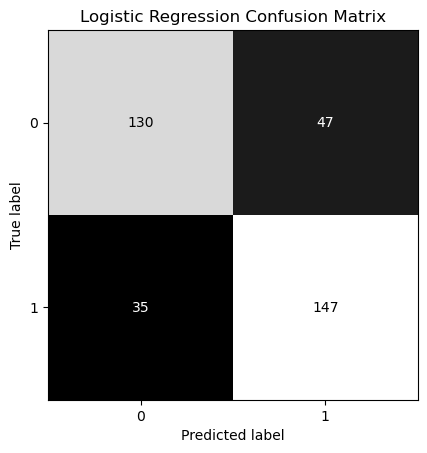

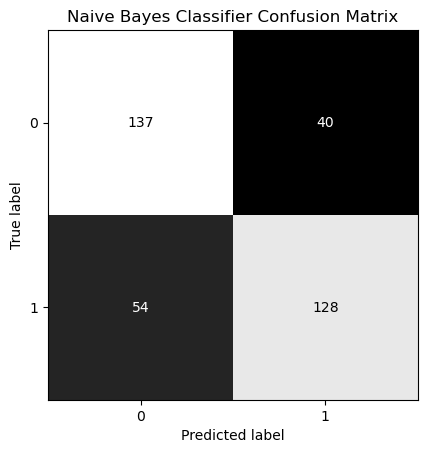

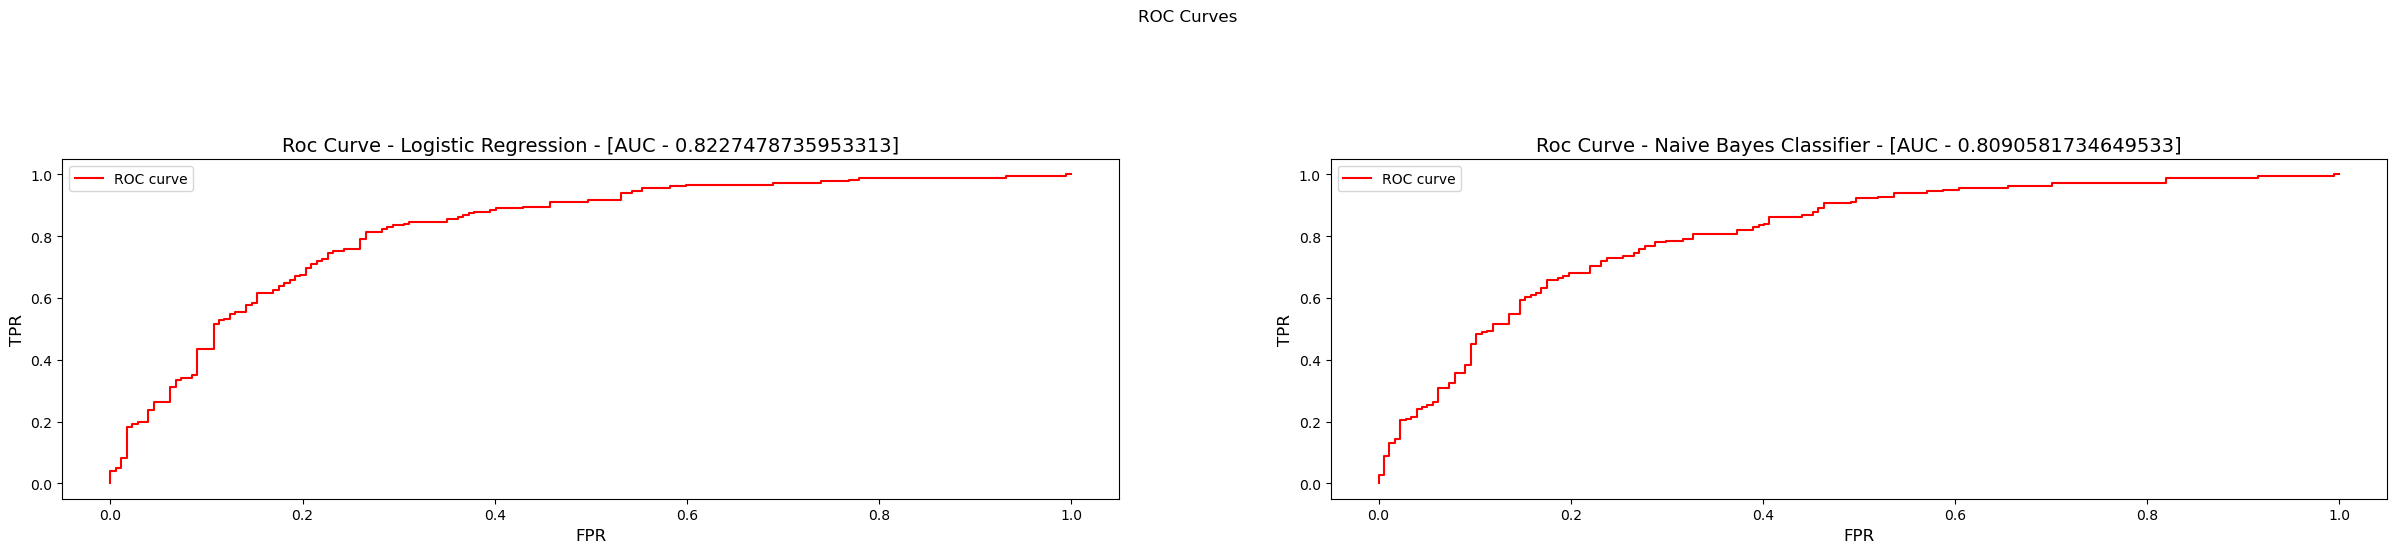

In [182]:
models = ['Logistic Regression', 'Naive Bayes Classifier']
predictions = [y_lc_predicted, y_nbc_predicted]
pred_probabilities = [y_lc_pred_proba, y_nbc_pred_proba]

plot = 1

for model, prediction, pred_proba in zip(models, predictions, pred_probabilities):
    disp = ConfusionMatrixDisplay(confusion_matrix(y_test.ravel(), prediction))
    disp.plot(
        include_values=True,
        cmap='gray',
        colorbar=False
    )
    disp.ax_.set_title(f"{model} Confusion Matrix")

plt.figure(figsize=(30, 15))
plt.suptitle("ROC Curves")
plot_index = 1

for model, prediction, pred_proba in zip(models, predictions, pred_probabilities):
    fpr, tpr, thresholds = roc_curve(y_test, pred_proba[:, 1])
    auc_score = auc(fpr, tpr)
    plt.subplot(3, 2, plot_index)
    plt.plot(fpr, tpr, 'r', label='ROC curve')
    plt.title(f'Roc Curve - {model} - [AUC - {auc_score}]', fontsize=14)
    plt.xlabel('FPR', fontsize=12)
    plt.ylabel('TPR', fontsize=12)
    plt.legend()
    plot_index += 1
plt.show()